In [26]:
import missingno as mno
from sklearn.cluster import KMeans
import pandas as pd
import pickle
import string
import re
import string
from sklearn.model_selection import cross_validate as cross_validation, ShuffleSplit, cross_val_score, train_test_split, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
import pickle

In [57]:
base_data = pd.read_pickle('basic_preprocessed_data.pkl')
data = pd.read_pickle('preprocessed_data.pkl')
data_oh = pd.read_pickle('onehot_encoded_clean_data.pkl')
data_cyl = pd.read_pickle('cyclical_encoded_data.pkl')

<AxesSubplot:>

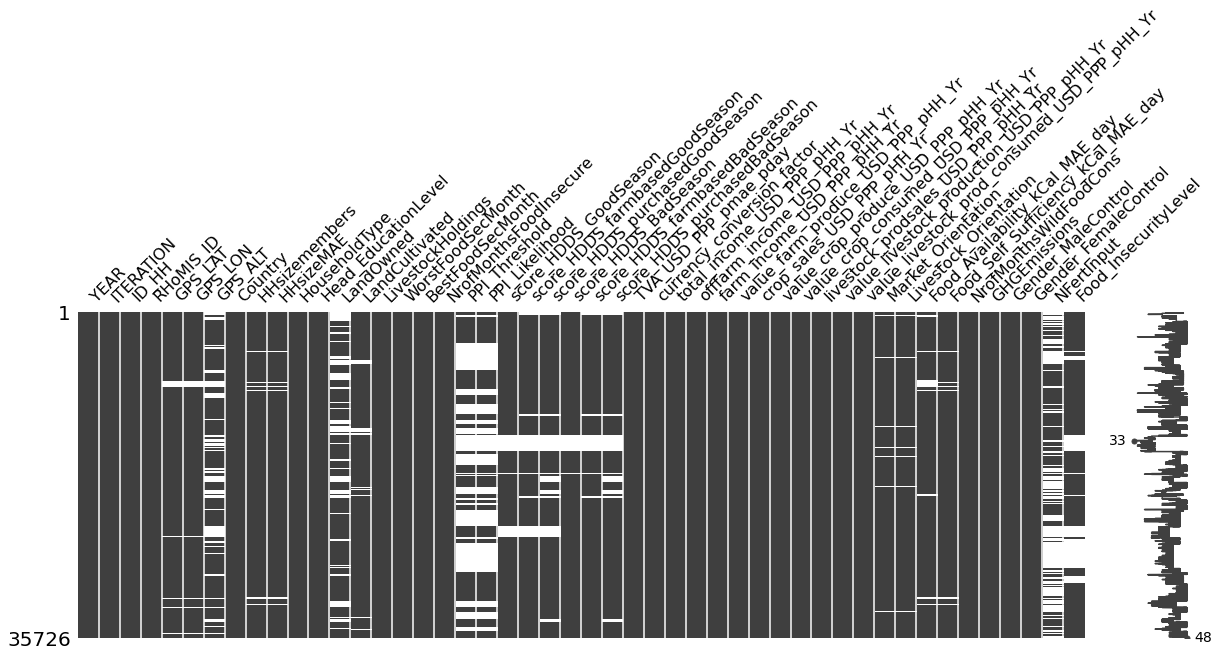

In [61]:
mno.matrix(data, figsize = (20, 6))

In [51]:
missing_data = pd.DataFrame(data[data.columns[data.isnull().any()]].isnull().sum()/len(data)*100)
missing_columns = []
for i in range(len(missing_data)):
        missing_columns.append(missing_data.iloc[i].name)


In [52]:
missing_columns

['GPS_LAT',
 'GPS_LON',
 'GPS_ALT',
 'HHsizemembers',
 'HHsizeMAE',
 'LandOwned',
 'LandCultivated',
 'PPI_Threshold',
 'PPI_Likelihood',
 'score_HDDS_GoodSeason',
 'score_HDDS_farmbasedGoodSeason',
 'score_HDDS_purchasedGoodSeason',
 'score_HDDS_BadSeason',
 'score_HDDS_farmbasedBadSeason',
 'score_HDDS_purchasedBadSeason',
 'Market_Orientation',
 'Livestock_Orientation',
 'Food_Availability_kCal_MAE_day',
 'Food_Self_Sufficiency_kCal_MAE_day',
 'NFertInput',
 'Food_InsecurityLevel']

In [53]:
# The function random_imputation replaces the missing values with some random observed values of the variable.
# The method is repeated for all the variables containing missing values ,
# after which they serve as parameters in the regression model to estimate other variable values.
# Simple Random Imputation is one of the crude methods since it ignores all the other available data and thus it's very rarely used.
# But it serves as a good starting point for regression imputation.

def random_imputation(df, feature):
    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)  
    return df

In [58]:
# drop id columns not necessary 
data_oh = data_oh.drop(['ID_HH','RHoMIS_ID'],axis=1)
for feature in missing_columns:
    data_oh[feature + '_imp'] = data_oh[feature]
    data_oh = random_imputation(data_oh, feature)

### Deterministic Regression Imputation 

In [59]:
# Deterministic Regression Imputation 


deter_data = pd.DataFrame(columns = ["Det" + name for name in missing_columns])

for feature in missing_columns:
        
    deter_data["Det" + feature] = data_oh[feature + "_imp"]
    parameters = list(set(data_oh.columns) - set(missing_columns) - {feature + '_imp'})
    
    #Create a Linear Regression model to estimate the missing data
    model = LinearRegression()
    model.fit(X = data_oh[parameters], y = data_oh[feature + '_imp'])
    
    #observe that I preserve the index of the missing data from the original dataframe
    deter_data.loc[data_oh[feature].isnull(), "Det" + feature] = model.predict(data_oh[parameters])[data_oh[feature].isnull()]

<AxesSubplot:>

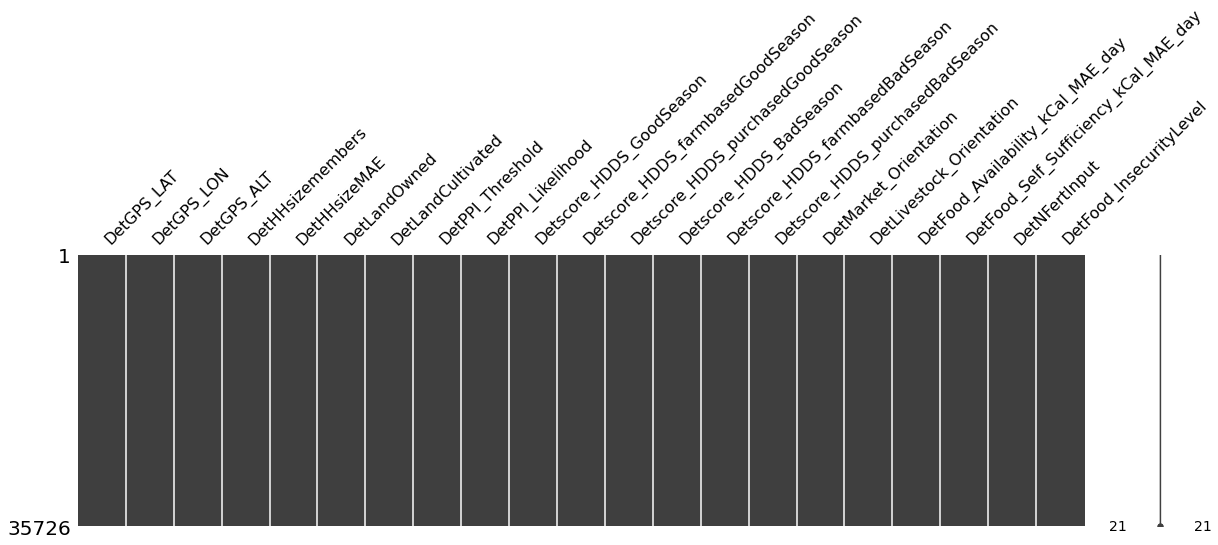

In [60]:
mno.matrix(deter_data, figsize = (20,5))

/opt/anaconda3/envs/flair_nlp/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/flair_nlp/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


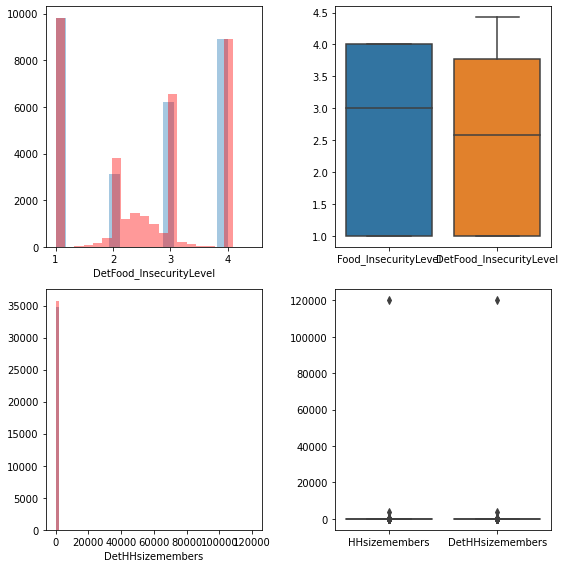

In [64]:
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(8, 8)

for index, variable in enumerate(["Food_InsecurityLevel",'HHsizemembers']):
    sns.distplot(data_oh[variable].dropna(), kde = False, ax = axes[index, 0])
    sns.distplot(deter_data["Det" + variable], kde = False, ax = axes[index, 0], color = 'red')
    
    sns.boxplot(data = pd.concat([data_oh[variable], deter_data["Det" + variable]], axis = 1),
                ax = axes[index, 1])
    
plt.tight_layout()